# Modélisation plus poussée
- Feature selection
- Modèle plus complexe (XGBoost)
- Finetuning des hyperparamètres/Cross Validation

### Chargement des données

In [1]:
import pandas as pd
from src.data_eng.prepare_db import *

full_dataset = load_dataset("telco_prepared.csv")
print("Le dataset contient", len(full_dataset), "lignes")

Le dataset contient 7043 lignes


Liste des colonnes:

In [2]:
print(full_dataset.columns)

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason', 'zip_code_threefirst_digit',
       'zip_code_twofirst_digit'],
      dtype='object')


### Définition des types de variables
Features en entrée par type

In [3]:
usefull_columns = ['Gender', 'Senior Citizen',
                   'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
                   'Multiple Lines', 'Internet Service', 'Online Security',
                   'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
                   'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
                   'Monthly Charges', 'Total Charges', 'CLTV', 'Churn Label', 'zip_code_twofirst_digit']
full_dataset = full_dataset[usefull_columns]
features = full_dataset.columns
continuous_features = [col for col in features if full_dataset[col].dtype != 'object']
print("Variables continues:", continuous_features)
categorical_features = [col for col in features if full_dataset[col].dtype == 'object']
print("Variables categoriques:", categorical_features)

Variables continues: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV', 'zip_code_twofirst_digit']
Variables categoriques: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Churn Label']


In [4]:
print("\nVariables oubliées:",
      (set(categorical_features).union(continuous_features)).difference(set(features)))


Variables oubliées: set()


On réattribue les bons typages

In [5]:
continuous_features = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']
categorical_features = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines',
                        'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
                        'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
                        'zip_code_twofirst_digit']

- Réencodage de la cible

In [6]:
target_column = "Churn Label"
full_dataset[target_column] = full_dataset[target_column].map({"Yes": 1, "No": 0})
print(full_dataset[target_column].unique())

[1 0]


### On encode les variables catégoriques avec du one-hot encoding

In [7]:
full_dataset_encoded = pd.get_dummies(full_dataset, columns=categorical_features, drop_first=True)

### On gère les valeurs manquantes de total charges

In [8]:
from sklearn.impute import SimpleImputer

train, test, valid = split_dataset(full_dataset_encoded, 0.8, 0.90)  # fonction custom mais on peut utiliser sklearn

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(train[["Total Charges"]])
train["Total Charges"] = imp.transform(train[["Total Charges"]])
test["Total Charges"] = imp.transform(test[["Total Charges"]])
valid["Total Charges"] = imp.transform(valid[["Total Charges"]])

### On divise le dataset en train/test

In [9]:
train_targets = train[target_column]
test_targets = test[target_column]
valid_targets = valid[target_column]
train = train.drop(columns=[target_column])
test = test.drop(columns=[target_column])
valid = valid.drop(columns=[target_column])
print("train:", len(train), "test", len(test), "valid", len(valid))

train: 5634 test 704 valid 705


### Selection de feature.
- Modèle de base pour avoir l'importance des features
- Sélection itérative en retirant les features les moins importantes
- Evaluation sur la base de test

In [10]:

from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score
from src.modelling.cross_validation import feature_selection

results_selection = feature_selection(XGBClassifier, train, train_targets, test, test_targets,
                                      metric=roc_auc_score)


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=37, Metric: 72.17%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=37, Metric: 72.17%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=37, Metric: 72.17%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=37, Metric: 72.17%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=37, Metric: 72.17%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=37, Metric: 72.17%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=37, Metric: 72.17%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.006, n=30, Metric: 72.17%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.007, n=29, Metric: 72.68%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.008, n=28, Metric: 71.10%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.008, n=27, Metric: 70.38%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.008, n=26, Metric: 72.01%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.008, n=25, Metric: 68.54%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.008, n=24, Metric: 69.27%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.009, n=23, Metric: 71.86%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.009, n=22, Metric: 71.22%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.009, n=21, Metric: 70.36%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.009, n=20, Metric: 71.00%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.009, n=19, Metric: 69.45%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.009, n=18, Metric: 69.38%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.010, n=17, Metric: 72.61%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.010, n=16, Metric: 71.09%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.010, n=15, Metric: 69.94%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.010, n=14, Metric: 70.58%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.010, n=13, Metric: 69.74%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.011, n=12, Metric: 69.61%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.013, n=11, Metric: 68.77%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.014, n=10, Metric: 68.80%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.016, n=9, Metric: 69.63%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.018, n=8, Metric: 69.58%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.020, n=7, Metric: 70.98%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.027, n=6, Metric: 69.01%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.039, n=5, Metric: 71.51%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.042, n=4, Metric: 71.51%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.064, n=3, Metric: 70.01%
Thresh=0.151, n=2, Metric: 50.00%
Thresh=0.429, n=1, Metric: 50.00%


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


- Affichage des performances en test en fonction du nombre de features en entrée

    treshold  number of features    metric  \
0   0.000000                  37  0.721695   
1   0.000000                  37  0.721695   
2   0.000000                  37  0.721695   
3   0.000000                  37  0.721695   
4   0.000000                  37  0.721695   
5   0.000000                  37  0.721695   
6   0.000000                  37  0.721695   
7   0.006305                  30  0.721695   
8   0.007074                  29  0.726786   
9   0.007627                  28  0.710976   
10  0.007667                  27  0.703848   
11  0.008120                  26  0.720055   
12  0.008282                  25  0.685379   
13  0.008456                  24  0.692732   
14  0.008514                  23  0.718554   
15  0.008544                  22  0.712219   
16  0.008624                  21  0.703623   
17  0.008781                  20  0.709958   
18  0.009059                  19  0.694458   
19  0.009467                  18  0.693750   
20  0.009744                  17  

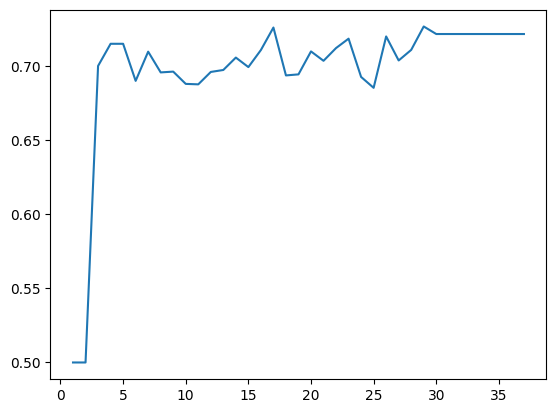

In [11]:
import matplotlib.pyplot as plt

results_selection = pd.DataFrame(results_selection)
plt.plot(results_selection["number of features"], results_selection["metric"])
print(results_selection)

- On ne garde que les variables sélectionnées

In [12]:
selected_features = results_selection[results_selection["number of features"] == 10]["selected_features"]

In [13]:
selected_features_list = selected_features.values[0].split(',')
train_selected = train[selected_features_list]
test_selected = test[selected_features_list]
valid_selected = valid[selected_features_list]

### On lance le finetuning du modèle avec une validation croisée.

In [14]:
from src.modelling.cross_validation import gridsearch_with_cv
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1)
params = {'learning_rate': [0.01, 0.05, 0.1],
          'max_depth': [2, 3, 4, 5],
          'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          "early_stopping_rounds": [5]}

res_grid = gridsearch_with_cv(train_selected, test_selected, test_targets, train_targets, parameters_grids=params,
                              num_params_iter_max=100,
                              cv_folds=5, estimator=xgb, metric='roc_auc')

[20:22:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-logloss:0.68947
[20:22:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-logloss:0.68945
[20:22:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-logloss:0.68947
[1]	validation_0-logloss:0.68551
[20:22:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-logloss:0.68950
[1]	validation_0-logloss:0.68564
[1]	validation_0-logloss:0.68556
[2]	validation_0-logloss:0.68197
[1]	validation_0

- On affiche les informations du meilleur modèle

In [15]:
print('\n Résultats du finetuning:')
results = pd.DataFrame(res_grid.cv_results_)
print(results)
print('\n Meilleur modèle:')
print(res_grid.best_estimator_)
print('\n Meilleurs paramètres:')
print(res_grid.best_params_)


 Résultats du finetuning:
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.146632      0.002191         0.004090        0.000234   
1        0.106002      0.002937         0.003519        0.000186   
2        0.141516      0.000927         0.004078        0.000101   
3        0.159495      0.001438         0.003739        0.000085   
4        0.114872      0.006991         0.003823        0.000164   
..            ...           ...              ...             ...   
95       0.223641      0.012261         0.005171        0.000256   
96       0.111937      0.011526         0.003724        0.000215   
97       0.192801      0.002400         0.004241        0.000124   
98       0.274483      0.003936         0.005611        0.000125   
99       0.231206      0.040548         0.004051        0.000259   

   param_subsample param_min_child_weight param_max_depth param_learning_rate  \
0              1.0                     10               3                0.

### On pickleise le meilleur modèle

In [16]:
from src.modelling.model_analysis import plot_feature_importance
import pickle

final_model = res_grid.best_estimator_
file = open('output/best_model.pickle', 'wb')
pickle.dump(final_model, file)
file.close()

### Performance du modèle en Validation

In [17]:
from sklearn.metrics import classification_report, auc, roc_curve
print("Distribution de la cible en validation :\n", valid_targets.value_counts())
prediction = final_model.predict(valid_selected)
disp = classification_report(valid_targets, prediction)
print("Performance en validation:\n", disp)
fpr, tpr, thresholds = roc_curve(valid_targets, prediction, pos_label=1)
print("AUC:", auc(fpr, tpr))



Distribution de la cible en validation :
 0    528
1    177
Name: Churn Label, dtype: int64
Performance en validation:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       528
           1       0.56      0.45      0.50       177

    accuracy                           0.77       705
   macro avg       0.69      0.67      0.68       705
weighted avg       0.76      0.77      0.76       705

AUC: 0.6663296096558808


In [18]:
prediction = final_model.predict(test_selected)
disp = classification_report(test_targets, prediction)
print("Performance en test:\n", disp)
fpr, tpr, thresholds = roc_curve(test_targets, prediction, pos_label=1)
print("AUC:", auc(fpr, tpr))

Performance en test:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       491
           1       0.69      0.54      0.61       213

    accuracy                           0.79       704
   macro avg       0.75      0.72      0.73       704
weighted avg       0.78      0.79      0.78       704

AUC: 0.7193473126607574


In [19]:
prediction = final_model.predict(train_selected)
disp = classification_report(train_targets, prediction)
print("Performance en train:\n", disp)
fpr, tpr, thresholds = roc_curve(train_targets, prediction, pos_label=1)
print("AUC:", auc(fpr, tpr))

Performance en train:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      4155
           1       0.68      0.55      0.61      1479

    accuracy                           0.82      5634
   macro avg       0.77      0.73      0.75      5634
weighted avg       0.81      0.82      0.81      5634

AUC: 0.7306153782314619


### Importance des variables du modèle

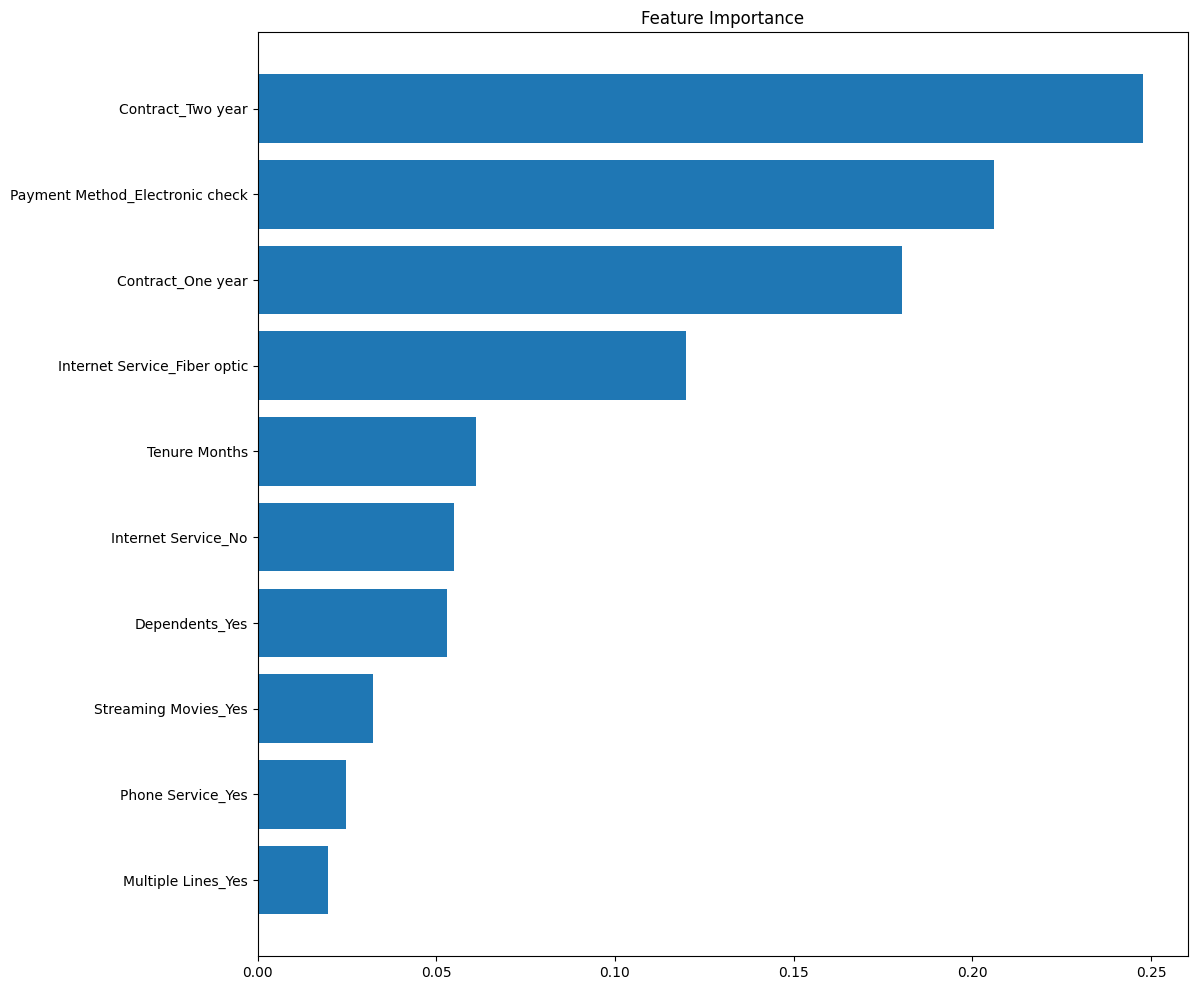

In [20]:
from src.modelling.model_analysis import plot_feature_importance
#final_model = model.fit(train_selected, train_targets, eval_set=[[test_selected, test_targets]])
plot_feature_importance(final_model, selected_features_list)

### Partial dependence plot des variables du modèle

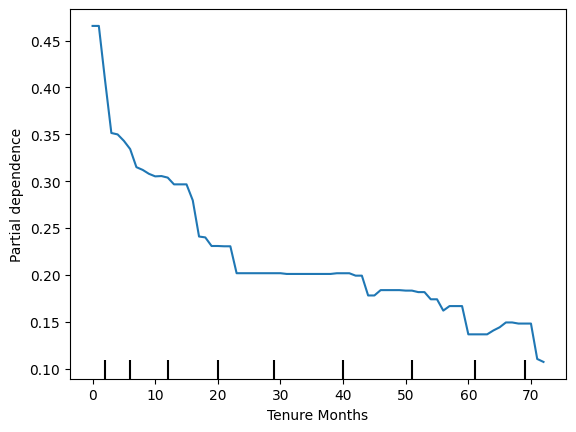

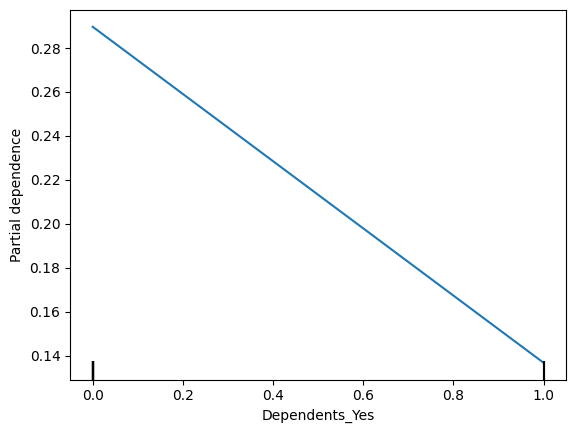

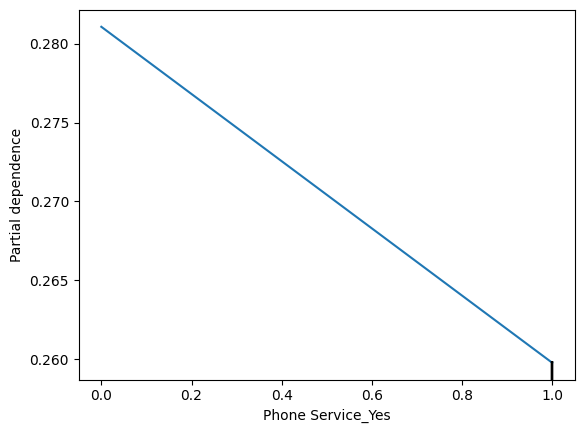

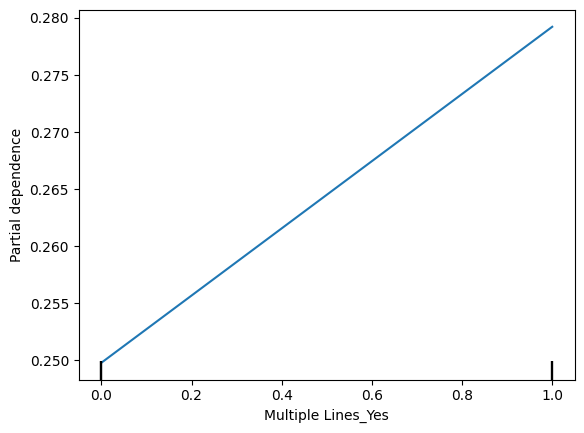

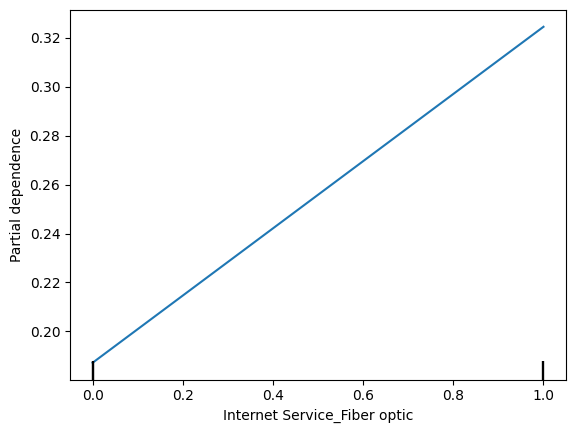

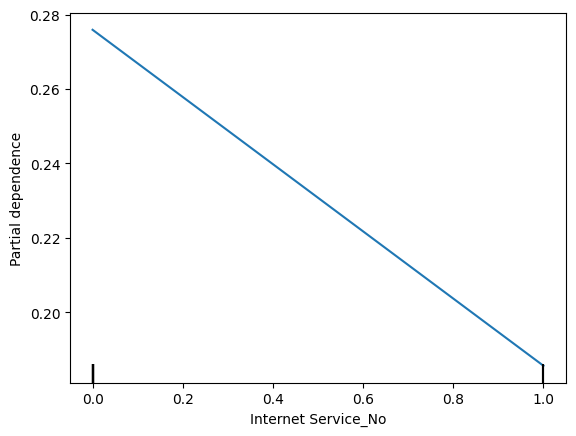

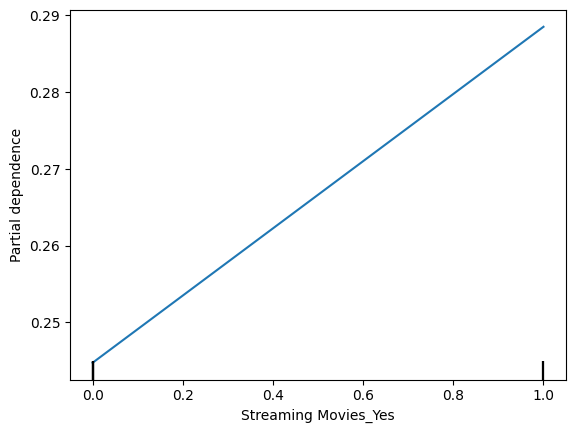

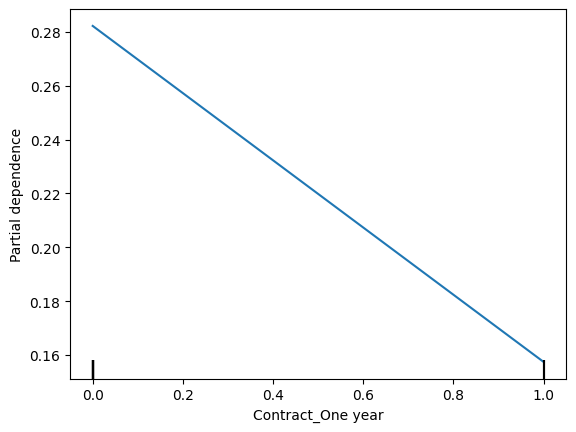

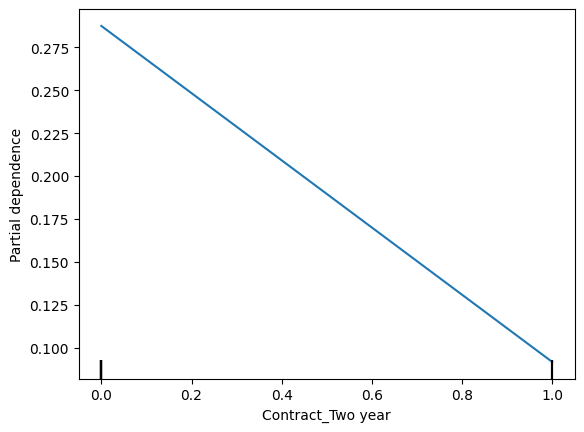

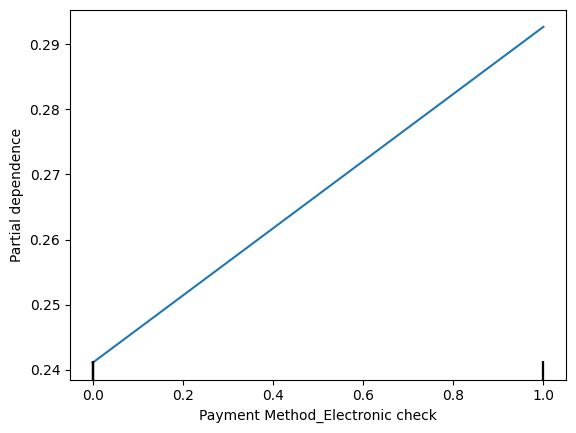

In [21]:
from src.modelling.model_analysis import save_and_plot_partial_dependence_plots

save_and_plot_partial_dependence_plots(final_model, train_selected, selected_features_list)

### Analyse des shapley values sur test

Exact explainer: 142it [00:11,  2.24it/s]                         


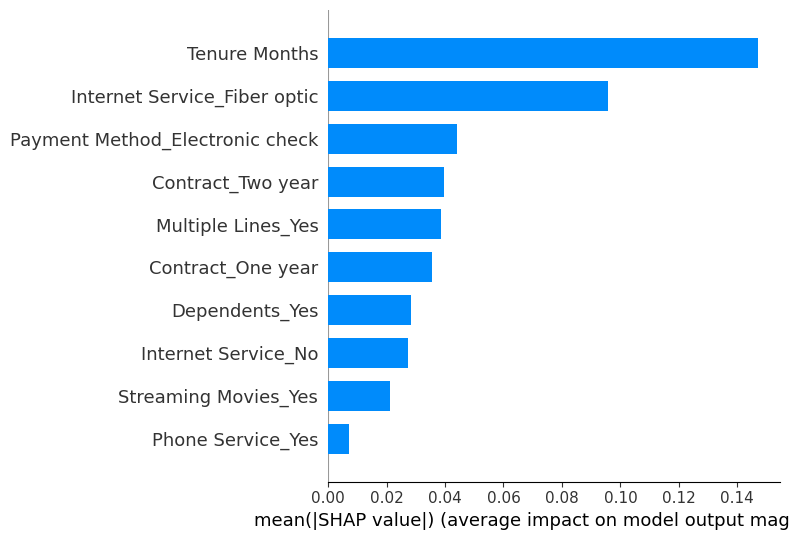

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


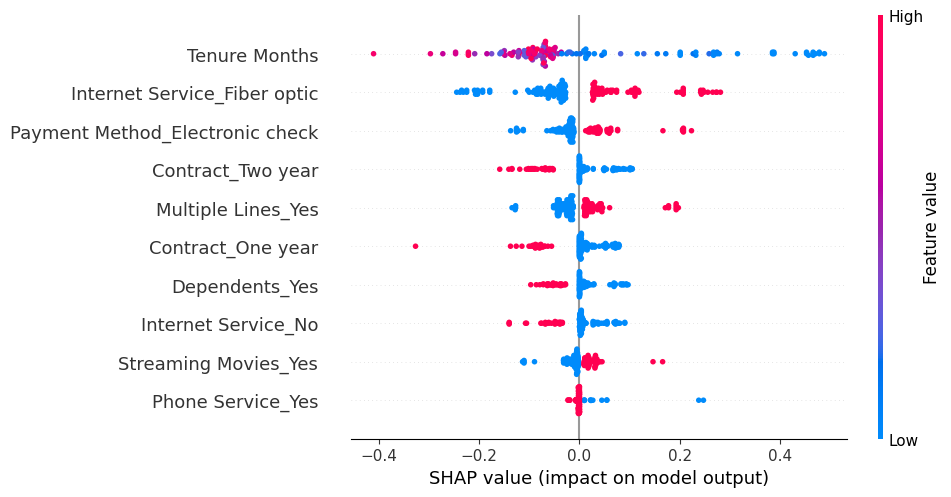

In [22]:
from src.modelling.model_analysis import plot_shapley_values

plot_shapley_values(final_model, test_selected, 0.2)